# Assignment 5 


In [18]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime


## Import data

In [19]:
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])  # First, ensure that "date" is in datetime format

## Compute Rolling Betas

In [44]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 1. Remove stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data 
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))


MergeError: Passing 'suffixes' which cause duplicate columns {'beta_x'} is not allowed.

## Sort Stocks by Beta Decile

In [43]:
# 1. Quintiles
data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
data['vw_Q'] = data['mcap']/data.groupby(['date','beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()



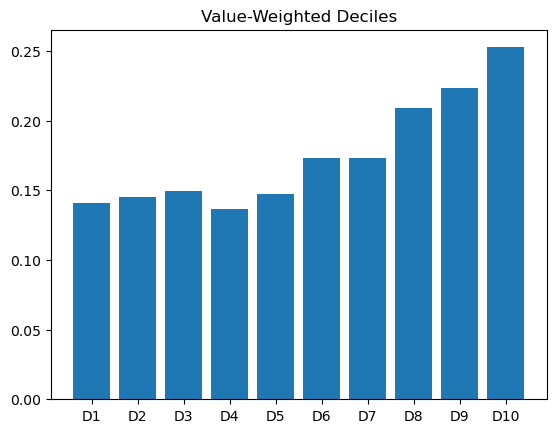

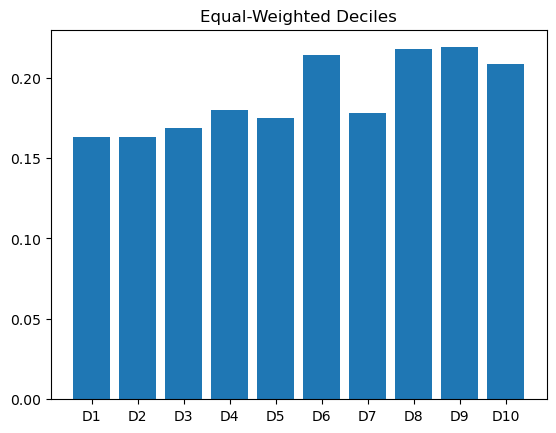

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles'),
 None)

In [37]:
# 5. Plot Histogram
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_ret_mean*12),plt.title('Value-Weighted Deciles'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_ret_mean*12),plt.title('Equal-Weighted Deciles'), plt.show()

## BAB Factor

In [41]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()

# Levered and unlevered returns
BAB['BAB1'] = BAB['R_L'] - BAB['R_H']
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']



## CAPM Alpha and Market Exposure

In [42]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
print('Beta BAB: ',beta_bab)
print('Market Risk Premium: ',market_rp)
print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.07996011153067123 3.685933014589582
Sharpe Ratio of BAB factor:  0.7765737090975785
Idiosyncatic volatility:  0.11537908538237354
Beta BAB:  0.3380077072120141
Market Risk Premium:  0.07055278019804107
Market Volatility:  0.19970133154217026


C:\Users\perusset\AppData\Local\Temp\ipykernel_19548\2854850227.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Alpha_bab = OLS_Reg.params[0]*12
C:\Users\perusset\AppData\Local\Temp\ipykernel_19548\2854850227.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_bab = OLS_Reg.params[1]
C:\Users\perusset\AppData\Local\Temp\ipykernel_19548\2854850227.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Annualized Alpha

## Is the BAB factor also dollar neutral in terms of risky securities only?
No, the risky returns $R^H$ and $R^L$ are levered differently by $\beta_H$ and $\beta_L$. Thus as long as $\beta_H \neq \beta_L$, the strategy will not be dollar neutral in terms of risky securities only. Note, that $R^H-R_L$ is dollar neutral in terms of risky securities only. But this portfolio has a positive beta. The levered BAB factor is both dollar neutral and has a zero beta (but it is not dollar neutral in terms of risky securities only).

## Interpretation of the tightness of the fundning constraint

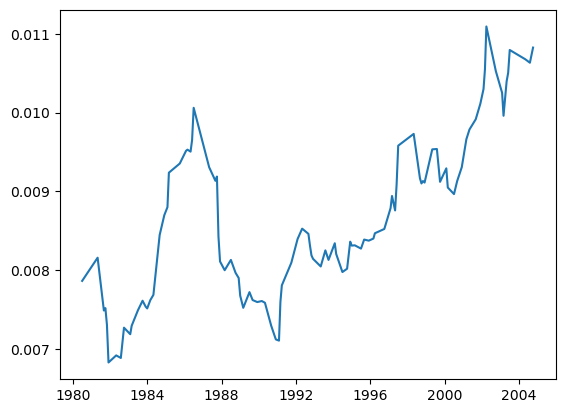

([<matplotlib.lines.Line2D at 0x1d3b1e5e650>], None)

In [40]:
# Plot rolling 10 year return
plt.plot(BAB['date'],BAB.rolling(240)['BAB2'].mean()),plt.show()

The expected betting against beta return is proportional to the tightness of the funding constraint $\psi:$

$$ E[R^{BAB}_{t+1}] = \frac{E[R^{L}_{t+1}]-R_f}{\beta^L}-\frac{E[R^{H}_{t+1}]-R_f}{\beta^H}  = \frac{\beta^H-\beta_L}{\beta^H\beta^L}\psi$$

The higher the expected return on the betting against beta factor the higher the funding constraint (holding the beta spread constant)